In [5]:
import json
import csv
import numpy as np
import sys

if "/home/jovyan/work/notebooks" not in sys.path:
    sys.path.insert(0, "/home/jovyan/work/notebooks")

from normalize_ratings import normalize_ratings

# list of which anime ID corresponds to which index in the rating vectors
corpus_ids = []
with open('./work/data/corpus_ids.json', 'rt') as f:
    corpus_ids = json.load(f)

min_ratings_to_consider = 30
corpus_size = len(corpus_ids)
ix_by_id = {aid: idx for idx, aid in enumerate(corpus_ids)}

# input vectors consist of both normalized ratings as well as as presence flags
# it's loaded like this:
# presence_mask = batch[:, :CONF['corpus_size']]
# true_ratings = batch[:, CONF['corpus_size']:]

input_vector_len = corpus_size * 2

input_vectors = []

def save_data(vectors):
    """Saves a list of vectors to a compressed npz file.

    Each vector is a tuple of (indices, values, rated_mask) where:
    - indices: array of corpus indices for shows in the user's list
    - values: normalized rating values
    - rated_mask: boolean array indicating if the show was actually rated (True) or guessed (False)
    """
    if not vectors:
        return

    # Flatten the list of (indices, values, rated_mask) tuples
    all_indices = []
    all_values = []
    all_rated_masks = []
    lengths = []

    for idxs, vals, rated in vectors:
        all_indices.append(idxs)
        all_values.append(vals)
        all_rated_masks.append(rated)
        lengths.append(len(idxs))

    packed_indices = np.concatenate(all_indices).astype(np.int16)
    packed_values = np.concatenate(all_values).astype(np.float32)
    concatenated_masks = np.concatenate(all_rated_masks).astype(np.uint8)
    packed_rated_masks = np.packbits(concatenated_masks)
    total_mask_bits = len(concatenated_masks)
    lengths = np.array(lengths, dtype=np.int32)

    filename = "./work/data/user_input_vectors.npz"
    np.savez(filename,
             indices=packed_indices,
             values=packed_values,
             lengths=lengths,
             rated_masks=packed_rated_masks,
             total_mask_bits=np.array([total_mask_bits], dtype=np.int64))
    print(f"Saved {len(vectors)} vectors to {filename}")
    print(f"  Packed {total_mask_bits} rating flags into {len(packed_rated_masks)} bytes")

def process_profile(user_ratings):
    indices = []
    valid_scores = []
    rated_flags = []

    for aid, score, status in user_ratings:
        ix = ix_by_id.get(aid, None)
        if ix is None:
            continue

        if status == 'plan_to_watch':
            continue

        if status == 'dropped' and score == 0:
            # Use -2 as a sentinel value for unrated dropped shows.
            # normalize_ratings will handle this by setting it to 1.5 stddevs below the mean.
            score = -2
            rated_flags.append(False)
        elif score == 0:
            # Unrated but watched/on_hold - will be filled with mean
            rated_flags.append(False)
        else:
            rated_flags.append(True)

        if status == 'on_hold' and score == 0:
            # don't include on-hold unrated shows; assuming this is unwatched.
            rated_flags.pop()
            continue

        # Note that score can be 0, which means the user hasn't rated it.
        #
        # These need to be handled specially during normalization.
        indices.append(ix)
        valid_scores.append(score)

    if not indices:
        return None

    indices = np.array(indices, dtype=np.int16)
    valid_scores = np.array(valid_scores, dtype=np.float32)
    rated_flags = np.array(rated_flags, dtype=bool)

    norm_ratings, stats = normalize_ratings(valid_scores)

    if current_user in ['ameo___']:
        print(f"User {current_user} normalization details:")
        print(f"  Mean (mu): {stats['mu']:.3f}, StdDev (sigma): {stats['sigma']:.3f}")
        print(f"  Adaptive alpha: {stats['alpha']:.3f}")
        print(f"  Original scores: {valid_scores}")
        print(f"  Z-score norm: {stats['zscore_norm']}")
        print(f"  Absolute norm: {stats['absolute_norm']}")
        print(f"  Final norm ratings: {norm_ratings}")
        print(f"  Rated flags: {rated_flags}")

    return indices, norm_ratings, rated_flags

# format is username,anime_id,score,watch_status,start_date_opt,end_date_opt
# it is sorted by username
with open("./work/data/collected_animelists.csv", "rt") as f:
    reader = csv.reader(f)
    current_user = None
    current_ratings = []

    row_ix = 0
    for row in reader:
        # skip header row
        if row_ix == 0:
            row_ix += 1
            continue
        row_ix += 1

        username = row[0]
        anime_id = int(row[1])
        score = float(row[2])
        status = row[3]  # 'watching', 'completed', 'on_hold', 'dropped', 'plan_to_watch'

        if username != current_user:
            if current_user is not None and len(current_ratings) >= min_ratings_to_consider:
                res = process_profile(current_ratings)
                if res is not None:
                    input_vectors.append(res)

                    if current_user in ['ameo___']:
                        print(f"Test user profile for {current_user}:")
                        print(res)

            current_user = username
            current_ratings = []

        current_ratings.append((anime_id, score, status))

        if row_ix % 1000000 == 0:
            print(f"Processed {row_ix} rows, current user: {current_user}, ratings collected: {len(current_ratings)}")

    if current_user is not None and len(current_ratings) >= min_ratings_to_consider:
        res = process_profile(current_ratings)
        if res is not None:
            input_vectors.append(res)

if input_vectors:
    save_data(input_vectors)

print("Processing complete.")

/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Processed 1000000 rows, current user: _Dare, ratings collected: 158
Processed 2000000 rows, current user: _Lxr, ratings collected: 154
Processed 3000000 rows, current user: _Tasu, ratings collected: 143
Processed 4000000 rows, current user: -Frozt, ratings collected: 332
Processed 5000000 rows, current user: -z0ck, ratings collected: 101
Processed 6000000 rows, current user: 12292001, ratings collected: 49
Processed 7000000 rows, current user: 21dumpy, ratings collected: 79
Processed 8000000 rows, current user: 420stonerdude420, ratings collected: 254
Processed 9000000 rows, current user: 7amzaElgad, ratings collected: 308
Processed 10000000 rows, current user: A1b5c9j14, ratings collected: 1052
Processed 11000000 rows, current user: ABCN, ratings collected: 185
Processed 12000000 rows, current user: Absolute_13, ratings collected: 328
Processed 13000000 rows, current user: Aci7, ratings collected: 393
Processed 14000000 rows, current user: adelinq, ratings collected: 63
Processed 1500

KeyboardInterrupt: 


Typical Fan (high mean, low variance)
Original scores: [8. 8. 7. 9. 8. 7. 6. 9. 8. 7.]
Mean: 7.70, Std: 0.90, Alpha: 0.35

Z-Score:          [ 0.33333316  0.33333316 -0.77777666  1.444443    0.33333316 -0.77777666
 -1.8888865   1.444443    0.33333316 -0.77777666]
Absolute:         [1.  1.  0.6 1.4 1.  0.6 0.2 1.4 1.  0.6]
Final normalized: [ 0.7692304   0.7692304   0.12307677  1.415384    0.7692304   0.12307677
 -0.52307695  1.415384    0.7692304   0.12307677]


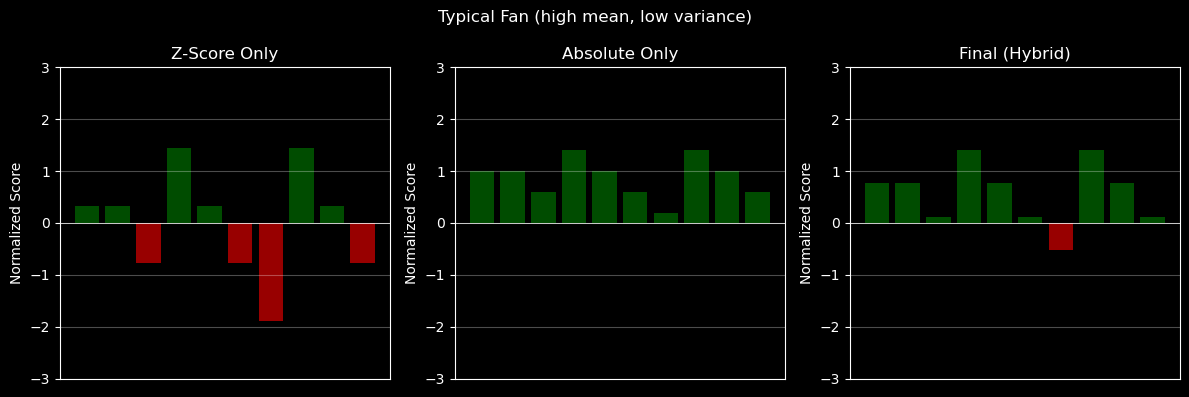


Critical Reviewer (medium mean, high variance)
Original scores: [3. 9. 5. 2. 7. 8. 4. 6. 9. 3.]
Mean: 5.60, Std: 2.46, Alpha: 0.80

Z-Score:          [-1.0579245   1.3834399  -0.24413641 -1.4648186   0.5696517   0.9765458
 -0.6510305   0.16275766  1.3834399  -1.0579245 ]
Absolute:         [-1.   1.4 -0.2 -1.4  0.6  1.  -0.6  0.2  1.4 -1. ]
Final normalized: [-1.0463396   1.3867519  -0.23530914 -1.4518548   0.5757214   0.98123664
 -0.6408244   0.17020614  1.3867519  -1.0463396 ]


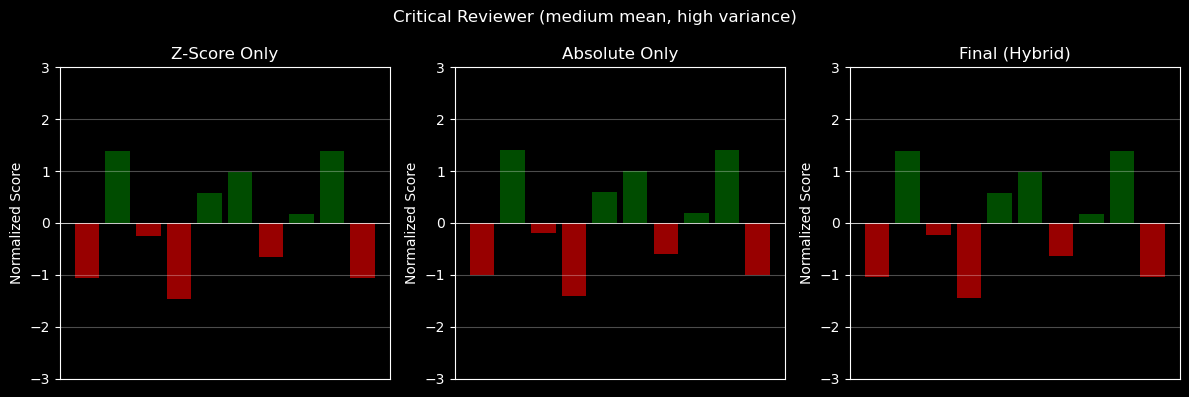


Harsh Critic (low mean, low variance)
Original scores: [4. 5. 3. 2. 4. 6. 3. 5. 4. 3.]
Mean: 3.90, Std: 1.14, Alpha: 0.44

Z-Score:          [ 0.08804493  0.96849513 -0.79240525 -1.6728554   0.08804493  1.8489453
 -0.79240525  0.96849513  0.08804493 -0.79240525]
Absolute:         [-0.6 -0.2 -1.  -1.4 -0.6  0.2 -1.  -0.2 -0.6 -1. ]
Final normalized: [-0.29943484  0.31044483 -0.90931445 -1.519194   -0.29943484  0.9203244
 -0.90931445  0.31044483 -0.29943484 -0.90931445]


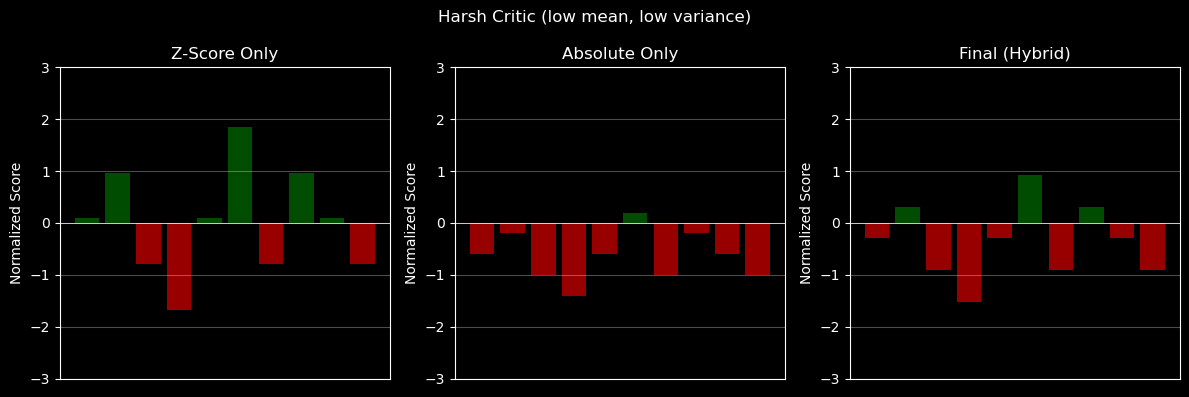


Loves Most, Hates Some (high mean, high variance)
Original scores: [10. 10.  9.  8. 10.  6.  8.  9. 10.  2.]
Mean: 8.20, Std: 2.40, Alpha: 0.80

Z-Score:          [ 0.74999976  0.74999976  0.33333325 -0.08333322  0.74999976 -0.9166662
 -0.08333322  0.33333325  0.74999976 -2.583332  ]
Absolute:         [ 1.8  1.8  1.4  1.   1.8  0.2  1.   1.4  1.8 -1.4]
Final normalized: [ 0.9599998   0.9599998   0.5466666   0.13333343  0.9599998  -0.69333297
  0.13333343  0.5466666   0.9599998  -2.3466656 ]


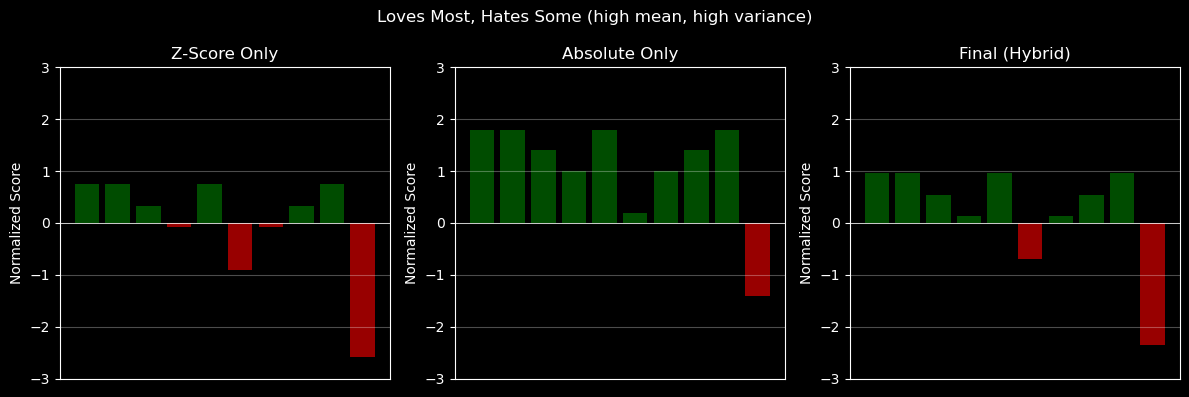


Me
Original scores: [ 7.  7.  8.  7.  0.  8.  7.  8. 10.  8.  2.  7.  5.  7.  0.  9.  8.  9.
  8.  8.  8. 10.  7. 10.  8.  8.  8.  8.  8.  7. 10.  8.  8.  8.  6. 10.
  9.  8.  8.  7.  7.  2.  8.  9.  0.  5. 10.  8.  6.  7.  8.  8.  9.  8.]
Mean: 7.69, Std: 1.61, Alpha: 0.62

Z-Score:          [-0.42499998 -0.42499998  0.19428569 -0.42499998  0.          0.19428569
 -0.42499998  0.19428569  1.432857    0.19428569 -3.         -0.42499998
 -1.6635714  -0.42499998  0.          0.8135714   0.19428569  0.8135714
  0.19428569  0.19428569  0.19428569  1.432857   -0.42499998  1.432857
  0.19428569  0.19428569  0.19428569  0.19428569  0.19428569 -0.42499998
  1.432857    0.19428569  0.19428569  0.19428569 -1.0442857   1.432857
  0.8135714   0.19428569  0.19428569 -0.42499998 -0.42499998 -3.
  0.19428569  0.8135714   0.         -1.6635714   1.432857    0.19428569
 -1.0442857  -0.42499998  0.19428569  0.19428569  0.8135714   0.19428569]
Absolute:         [ 0.6        0.6        1.         0.6    

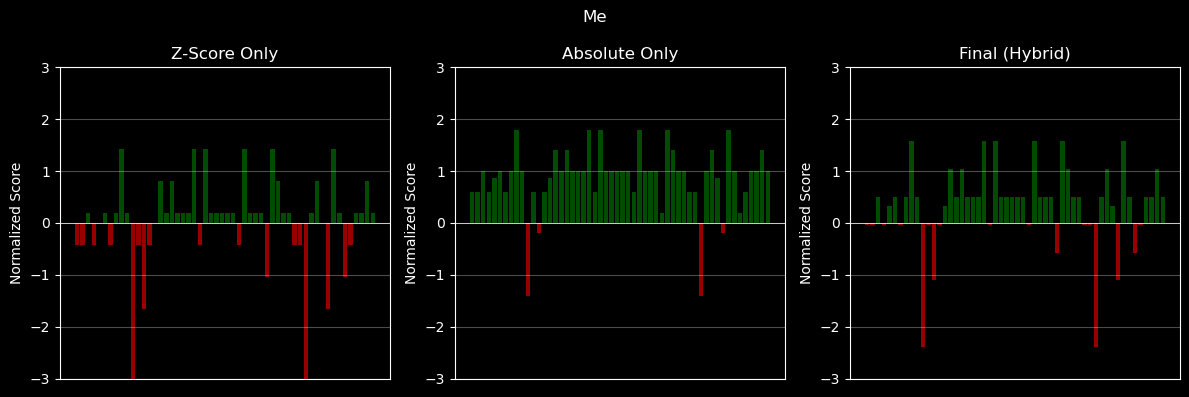


With Unrated Dropped Shows (-2 sentinel)
Original scores: [ 8.  7.  9. -2.  8.  7. -2. 10.  8.]
Mean: 8.14, Std: 0.99, Alpha: 0.38

Z-Score:          [-0.14433783 -1.1546997   0.8660241  -1.5000002  -0.14433783 -1.1546997
 -1.5000002   1.8763859  -0.14433783]
Absolute:         [1.         0.6        1.4        0.46329632 1.         0.6
 0.46329632 1.8        1.        ]
Final normalized: [ 0.56438386 -0.06796309  1.1967309  -0.2840736   0.56438386 -0.06796309
 -0.2840736   1.829078    0.56438386]


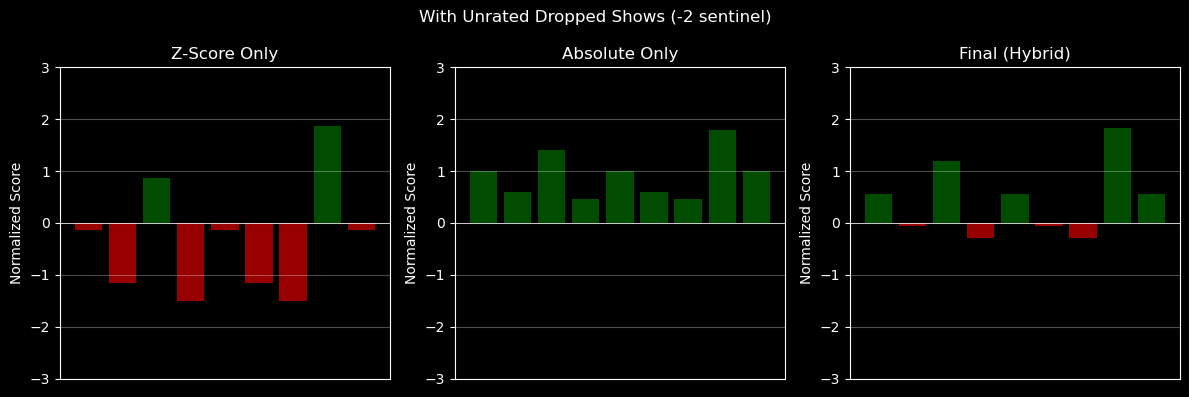

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Use dark theme for blog post compatibility
plt.style.use('dark_background')

def test_normalization(scores, title):
    scores = np.array(scores, dtype=np.float32)

    norm_ratings, stats = normalize_ratings(scores)

    mu = stats['mu']
    sigma = stats['sigma']
    alpha = stats['alpha']
    zscore_norm = stats['zscore_norm']
    absolute_norm = stats['absolute_norm']

    print(f"\n{title}")
    print(f"Original scores: {scores}")
    print(f"Mean: {mu:.2f}, Std: {sigma:.2f}, Alpha: {alpha:.2f}")
    print(f"\nZ-Score:          {zscore_norm}")
    print(f"Absolute:         {absolute_norm}")
    print(f"Final normalized: {norm_ratings}")

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    methods = [
        ("Z-Score Only", zscore_norm),
        ("Absolute Only", absolute_norm),
        ("Final (Hybrid)", norm_ratings)
    ]

    for ax, (method_name, values) in zip(axes, methods):
        x = np.arange(len(values))
        colors = ['red' if v < 0 else 'green' for v in values]
        ax.bar(x, values, color=colors, alpha=0.6)
        ax.axhline(y=0, color='white', linestyle='-', linewidth=0.5)
        ax.set_ylim(-3, 3)
        ax.set_title(method_name)
        # disable x labels for clarity
        ax.set_xticks([])
        ax.set_ylabel("Normalized Score")
        ax.grid(True, alpha=0.3)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Test Case 1: Typical fan (likes most things, narrow range)
test_normalization(
    [8, 8, 7, 9, 8, 7, 6, 9, 8, 7],
    "Typical Fan (high mean, low variance)"
)

# Test Case 2: Critical reviewer (wide range, lower mean)
test_normalization(
    [3, 9, 5, 2, 7, 8, 4, 6, 9, 3],
    "Critical Reviewer (medium mean, high variance)"
)

# Test Case 3: Harsh critic (mostly dislikes)
test_normalization(
    [4, 5, 3, 2, 4, 6, 3, 5, 4, 3],
    "Harsh Critic (low mean, low variance)"
)

# Test Case 4: Mixed with extremes
test_normalization(
    [10, 10, 9, 8, 10, 6, 8, 9, 10, 2],
    "Loves Most, Hates Some (high mean, high variance)"
)

# me
test_normalization(
    [7., 7., 8., 7., 0., 8., 7., 8., 10., 8., 2., 7., 5., 7., 0., 9., 8., 9., 8., 8., 8., 10., 7., 10., 8., 8., 8., 8., 8., 7., 10., 8., 8., 8., 6., 10., 9., 8., 8., 7., 7., 2., 8., 9., 0., 5., 10., 8., 6., 7., 8., 8., 9., 8.],
    "Me"
)

# Test Case 6: With unrated dropped shows (-2 sentinel)
test_normalization(
    [8, 7, 9, -2, 8, 7, -2, 10, 8],
    "With Unrated Dropped Shows (-2 sentinel)"
)